<a href="https://colab.research.google.com/github/kovasant/ids/blob/main/kov_ips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#εγκατάσταση πακέτου tensorflow (hhttps://www.tensorflow.org/)
!pip install tensorflow
#εγκατάσταση πακέτου scikit-learn (https://scikit-learn.org/)
!pip install scikit-learn

Unique classes in the data:  ['0.0' '1.0' '2.0']
train_data.shape= (10476, 20)
test_data.shape= (2994, 20)
test_data.shape= (1497, 20)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20, 1)]           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 20, 64)            256       
                                                                 
 conv1d_19 (Conv1D)          (None, 20, 64)            12352     
                                                                 
 flatten_9 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_9 (Dropout)         (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1s 26ms/step - loss: 1.5570 - acc: 0.3628 - val_loss: 1.1400 - val_acc: 0.6613
best_model= model5class.weights.002-0.9566.hdf5
TEST DATA-Confusion matrix:
94/94 [==============================] - 0s 3ms/step
[[1000    1    0]
 [  25  882   96]
 [   0    0  990]]
WebDDoS = 0.999000999000999
BENIGN = 0.8793619142572283
UDP-lag = 1.0


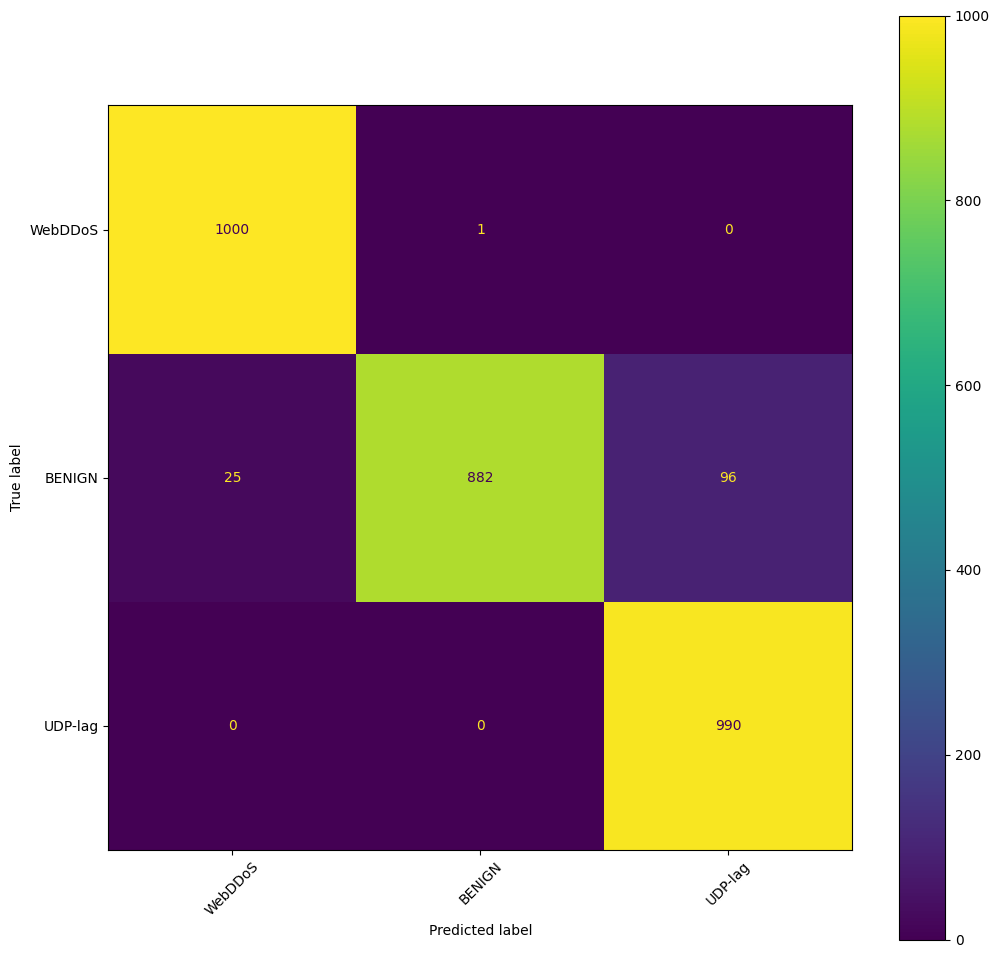

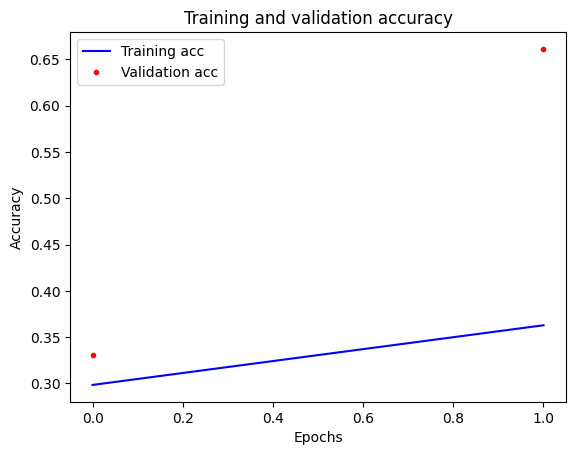

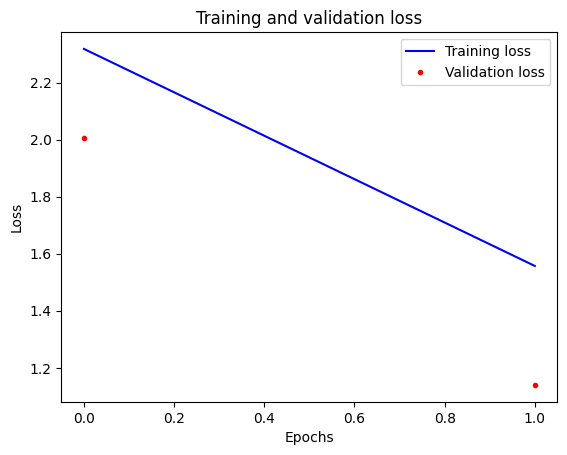

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
An example Intrusion Detection application using Dense, Conv1d and Lstm layers
please cite below works if you find it useful:
Akgun, Devrim, Selman Hizal, and Unal Cavusoglu. "A new DDoS attacks intrusion detection
model based on deep learning for cybersecurity." Computers & Security 118 (2022): 102748.

Hizal, Selman, Ünal ÇAVUŞOĞLU, and Devrim AKGÜN. "A New Deep Learning Based Intrusion
Detection System for Cloud Security." 2021 3rd International Congress on Human-Computer
Interaction, Optimization and Robotic Applications (HORA). IEEE, 2021.
"""


import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from models import models_ddos

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


epochs = 2
nclass = 12

def loadDataset():
    # Put dataset path here !
    # filename='/media/com/WORKSPACE/Dataset/IDS/ddos2019/68_13_RANDOM_672739.csv'
    filename='pcap_data.csv'
    trainfile = pd.read_csv(filename)
    data = pd.DataFrame(trainfile).to_numpy()
    data=data[data[:,-1]!='DrDoS_LDAP']
    np.random.shuffle(data)

    label = data[:,-1].astype('str')

    # Εκτύπωση των μοναδικών κλάσεων
    unique_classes = np.unique(label)
    print("Unique classes in the data: ", unique_classes)


    label[label == 'WebDDoS']       = 0
    label[label == 'BENIGN']        = 1
    label[label == 'UDP-lag']       = 2
    label[label == 'DrDoS_NTP']     = 3
    label[label == 'Syn']           = 4
    label[label == 'DrDoS_SSDP']    = 5
    label[label == 'DrDoS_UDP']     = 6
    label[label == 'DrDoS_NetBIOS'] = 7
    label[label == 'DrDoS_MSSQL']   = 8
    label[label == 'DrDoS_SNMP']    = 9
    label[label == 'TFTP']          = 10
    label[label == 'DrDoS_DNS']     = 11
    #label[label == 'DrDoS_LDAP']     = 11

    # SELECT FEATURES ----------------------------------------------------
    inx_sel=np.array([38,47,37,48,11,9,7,52,10,36,1,34,4,17,19,57,21,
                  18,22,24,32,50,23,55,51,5,3,39,40,43,58,12,25,
                  20,2,35,67,33,6,53])

  # Ελέγχουμε αν οι δείκτες είναι μεγαλύτεροι από τον αριθμό των στηλών
    inx_sel = inx_sel[inx_sel < data.shape[1]]

    # MIN-MAX normalization
    data=data[:,inx_sel]
    dmin = data.min(axis=0)
    dmax = data.max(axis=0)
    data=(data-dmin)/(dmax-dmin)
    # data = np.log(data-dmin+1.0)


    # Test data 20%
    train_data, test_data, train_label, test_label = \
        train_test_split(data, label, test_size=0.20, stratify=label)

    # Train 70%, Validation%10
    train_data, val_data, train_label, val_label = \
        train_test_split(train_data, train_label,test_size=0.125, stratify=train_label)


    return train_data.astype('float32'), train_label.astype('float32'), \
        val_data.astype('float32'), val_label.astype('float32'), \
            test_data.astype('float32'), test_label.astype('float32')

# -- LOAD DATA -----------------------------------------------------------------
train_data, train_labelp, val_data, val_labelp, test_data, test_labelp = loadDataset()

# to_categorical
train_label = to_categorical(train_labelp, nclass)
val_label   = to_categorical(val_labelp,   nclass)
test_label  = to_categorical(test_labelp,  nclass)

print('train_data.shape=', train_data.shape)
print('test_data.shape=',  test_data.shape)
print('test_data.shape=',  val_data.shape)

#get the number of features
inshape=train_data.shape[1]

# Class balancing weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(
                                                      train_labelp),
                                                  y=train_labelp)


class_weights = {i: class_weights[i] for i in range(len(class_weights))}


# -- CALLBACKS -----------------------------------------------------------------
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=30,
                              verbose=0,
                              mode='min')

modelCheckPoint = ModelCheckpoint('./savemodels/model5class.weights.{epoch:03d}-{val_acc:.4f}.hdf5',
                                  save_best_only=True,
                                  monitor='val_acc',
                                  mode='max')

# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
#                                   factor=0.1,
#                                   patience=7,
#                                   verbose=1,
#                                   epsilon=1e-4,
#                                   mode='min')

# -- Baseline models-----------------------------------------------------------

# -- Conv1d
model=models_ddos.model_conv1D(lr=1e-4,N=64,inshape=inshape)
# -- Dense
# model=models_ddos.model_dense(lr=1e-4,N=64,inshape=inshape)
# -- LSTM
# model=models_ddos.model_lstm(lr=1e-4,N=64,inshape=inshape)

model.summary()
# -----------------------------------------------------------------------------
# print model to an image file
# dot_img_file = 'model1.png'
# plot_model(model, to_file=dot_img_file, show_shapes=True)

# -- TRAIN MODEL --------------------------------------------------------------
history = model.fit(train_data,
                    train_label,
                    shuffle=True,
                    epochs=epochs,
                    batch_size=256,  # 256,#128,#32, 64
                    # validation_data=validation_generator,
                    # validation_split=0.2,
                    # validation_data=(val_data,val_label),
                    validation_data=(val_data, val_label),
                    callbacks=[modelCheckPoint],
                    class_weight=class_weights,
                    workers=3)
# Εκτέλεση αντίδρασης
reaction_enabled = True
if reaction_enabled:
    # Προσθήκη αντίδρασης -  Όταν εντοπίζεται μη αυτόματη παρέμβαση
    def send_notification(subject, message):
        # Ρυθμίσεις SMTP
        sender_email = "ekpa@lessons.kovix.gr"
        receiver_email = "ekpa@lessons.kovix.gr"
        password = "Qng3^59s8"
        smtp_server = "lessons.kovix.gr"
        smtp_port = 25

        # Δημιουργία μηνύματος email
        msg = MIMEMultipart()
        msg['From'] = sender_email
        msg['To'] = receiver_email
        msg['Subject'] = subject
        body = message
        msg.attach(MIMEText(body, 'plain'))

        # Αποστολή email
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()  # Ενεργοποίηση TLS
            server.login(sender_email, password)
            server.send_message(msg)

# Χρησιμοποίoυμε την send_notification για να ειδοποιήσουμε τους διαχειριστές
# Όταν εντοπίζεται μη αυτόματη παρέμβαση
# Παράδειγμα: Αποστολή email με ειδοποίηση
send_notification("Ειδοποίηση IDS", "Εντοπίστηκε μη αυτόματη παρέμβαση στο σύστημα IDS.")


# -- Load best model ----------------------------------------------------------
str_models = os.listdir('./savemodels')
str_models = np.sort(str_models)
best_model = str_models[str_models.size-1]
print('best_model=', best_model)
model.load_weights('./savemodels/'+best_model)

# --Confusion matrix ----------------------------------------------------------
print('TEST DATA-Confusion matrix:')
pred = model.predict(test_data)
pred_y = pred.argmax(axis=-1)

cm = confusion_matrix(test_labelp.astype('int32'), pred_y)
print(cm)

# # Εκτύπωση της ακρίβειας για κάθε κλάση που υπάρχει στα δεδομένα ελέγχου
# classes = ["WebDDoS", "BENIGN", "UDP-lag", "DrDoS_NTP", "Syn", "DrDoS_SSDP", "DrDoS_UDP", "DrDoS_NetBIOS", "DrDoS_MSSQL", "DrDoS_SNMP", "TFTP", "DrDoS_DNS"]
# for i in range(cm.shape[0]):
#     print(f'{classes[i]} =', cm[i, i]/np.sum(cm[i, :]))

# Εκτύπωση της ακρίβειας για κάθε κλάση που υπάρχει στα δεδομένα ελέγχου
classes = ["WebDDoS", "BENIGN", "UDP-lag", "DrDoS_NTP", "Syn", "DrDoS_SSDP", "DrDoS_UDP", "DrDoS_NetBIOS", "DrDoS_MSSQL", "DrDoS_SNMP", "TFTP", "DrDoS_DNS"]
for i in range(min(len(classes), cm.shape[0])):
    print(f'{classes[i]} =', cm[i, i]/np.sum(cm[i, :]))


# print('Accuracy ratios for each class')
# print('WebDDoS      =', cm[0, 0]/np.sum(cm[0, :]))
# print('BENIGN       =', cm[1, 1]/np.sum(cm[1, :]))
# print('UDP-lag      =', cm[2, 2]/np.sum(cm[2, :]))
# print('DrDoS_NTP    =', cm[3, 3]/np.sum(cm[3, :]))
# print('Syn          =', cm[4, 4]/np.sum(cm[4, :]))
# print('DrDoS_SSDP   =', cm[5, 5]/np.sum(cm[5, :]))
# print('DrDoS_UDP    =', cm[6, 6]/np.sum(cm[6, :]))
# print('DrDoS_NetBIOS=', cm[7, 7]/np.sum(cm[7, :]))
# print('DrDoS_MSSQL  =', cm[8, 8]/np.sum(cm[8, :]))
# print('DrDoS_SNMP   =', cm[9, 9]/np.sum(cm[9, :]))
# print('TFTP         =', cm[10,10]/np.sum(cm[10, :]))
# print('DrDoS_DNS    =', cm[11,11]/np.sum(cm[11, :]))


# -- Confusion matrix plot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
label=np.array(classes[:cm.shape[0]])

cmo = ConfusionMatrixDisplay(cm,display_labels=label)
fig, ax = plt.subplots(figsize=(12,12))
cmo.plot(ax=ax, xticks_rotation=45)

# Plot training and validation accurry and loss graphs
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

np.save('historydata.npy',[acc,val_acc,loss,val_loss])
[acc, val_acc, loss, val_loss] = np.load('historydata.npy')

plt.figure()
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()